In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('data.csv')
df.shape

(10568, 18)

In [3]:
dummies_genre = pd.get_dummies(df['genre']).rename(columns=lambda x: 'genre_' + str(x))
dummies_target = pd.get_dummies(df['target']).rename(columns=lambda x: 'target_' + str(x))
dummies_year = pd.get_dummies(df['year']).rename(columns=lambda x: 'year_' + str(x))
dummies_month = pd.get_dummies(df['month']).rename(columns=lambda x: 'month_' + str(x))
dummies_grade_level = pd.get_dummies(df['grade_level']).rename(columns=lambda x: 'grade_level_' + str(x))

df = pd.concat([df, dummies_genre, dummies_target, dummies_year, dummies_month, dummies_grade_level], axis=1)
df.head()

,author,artist,title,genre,date,review_abstract,score,target,year,month,...,grade_level_22,grade_level_23,grade_level_24,grade_level_25,grade_level_26,grade_level_27,grade_level_28,grade_level_29,grade_level_31,grade_level_32
0,Ben Cardew,Tricky,Fall to Pieces,Electronic,2020-09-05,"After a string of misfires, the UK musician’s ...",7.6,medium,2020,September,...,0,0,0,0,0,0,0,0,0,0
1,Brian Howe,Library Tapes,The Quiet City,ElectronicRock,2020-09-05,The Swedish minimalist composer David Wenngren...,7.0,medium,2020,September,...,0,0,0,0,0,0,0,0,0,0
2,Mike Powell,Bill Callahan,Gold Record,Rock,2020-09-04,"On his latest solo record, the singer-songwrit...",8.0,high,2020,September,...,0,0,0,0,0,0,0,0,0,0
3,Zach Schonfeld,Freak Heat Waves,Zap the Planet,RockExperimental,2020-09-04,The funky and hypnotic fourth album from the C...,7.8,medium,2020,September,...,0,0,0,0,0,0,0,0,0,0
4,Alphonse Pierre,YLZoomo,Born Again,Rap,2020-09-04,The NYC rapper YL’s music is full of slice-of-...,7.1,medium,2020,September,...,0,0,0,0,0,0,0,0,0,0


In [4]:
num_cols = df[['score', 'reading_ease', 'word_count']]

In [5]:
num_col_array = np.array(num_cols)

In [6]:
scaler = StandardScaler()

nca_fitted = scaler.fit_transform(num_col_array)


In [7]:
nca_df = pd.DataFrame(nca_fitted)

nca_df.head()

,0,1,2
0,0.408663,0.341412,-0.761603
1,-0.167760,0.847959,-0.143450
2,0.792945,-1.621769,-0.231757
3,0.600804,1.396926,-0.761603
4,-0.071689,1.249079,-1.291448


In [8]:
nca_df = nca_df.rename(columns={0:"score_scaled", 1:"reading_ease_scaled", 2:"word_count_scaled"})

In [9]:
df = pd.concat([df, nca_df], axis=1)

In [10]:
scaled_df = df.drop(['author', 'artist', 'title', 'genre', 'date', 'review_abstract', 'target','score', 'year', 'month', 'reading_ease', 'word_count', 'grade_level'], axis=1)

In [11]:
X = scaled_df.drop('high', axis=1)
y = scaled_df['high']

In [12]:
X.shape

(10568, 167)

In [13]:
X = X.drop(columns=['target_high', 'target_medium', 'target_low', 'score_scaled'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=23)

**Smote for train sets**

In [15]:
unique, count = np.unique(y_train, return_counts=True)
y_train_dict = {k:v for(k,v) in zip(unique,count)}
y_train_dict

{0: 5932, 1: 1465}

In [16]:
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
X_train_smote, y_train_smote = sm.fit_sample(X_train.astype('float'), y_train)

In [17]:
unique, count = np.unique(y_train_smote, return_counts=True)
y_train_smote_dict = {k:v for(k,v) in zip(unique,count)}
y_train_smote_dict

{0: 5932, 1: 5932}

**Smote for test sets**

In [18]:
unique, count = np.unique(y_test, return_counts=True)
y_train_dict = {k:v for(k,v) in zip(unique,count)}
y_train_dict

{0: 2549, 1: 622}

In [19]:
sm = SMOTE(random_state=12, sampling_strategy = 1.0)
X_test_smote, y_test_smote = sm.fit_sample(X_test.astype('float'), y_test)

In [20]:
unique, count = np.unique(y_test_smote, return_counts=True)
y_test_smote_dict = {k:v for(k,v) in zip(unique,count)}
y_test_smote_dict

{0: 2549, 1: 2549}

**Random Forest**

In [21]:
clf = RandomForestClassifier()

parameters = {'n_estimators': [250], 
              'max_features': ['sqrt'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [50], 
              'min_samples_split': [6],
              'min_samples_leaf': [1,5,8],
             }

roc_auc = make_scorer(roc_auc_score)

grid_obj = GridSearchCV(clf, parameters, scoring=roc_auc)
grid_obj = grid_obj.fit(X_train_smote, y_train_smote)

clf = grid_obj.best_estimator_

clf.fit(X_train_smote, y_train_smote)

#['log2', 'sqrt','auto']

RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=6,
                       n_estimators=250)

In [22]:
predictions_rf = clf.predict(X_test_smote)
print(accuracy_score(y_test_smote, predictions_rf))

0.8209101608473911


In [23]:
confusion_matrix(y_test_smote, predictions_rf)

array([[2430,  119],
       [ 794, 1755]], dtype=int64)

In [24]:
print(classification_report(y_test_smote, predictions_rf))

              precision    recall  f1-score   support

           0       0.75      0.95      0.84      2549
           1       0.94      0.69      0.79      2549

    accuracy                           0.82      5098
   macro avg       0.85      0.82      0.82      5098
weighted avg       0.85      0.82      0.82      5098



**Linear Regression**

In [25]:
lr = LogisticRegression()

parameters = {'penalty': ['l2'],
              'C': [5, 10],
              'random_state': [0],
              'max_iter': [1000]}

roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                                needs_threshold=True)
grid_obj_lr = GridSearchCV(lr, parameters, scoring=roc_auc)
grid_obj_lr = grid_obj_lr.fit(X_train_smote, y_train_smote)

lr = grid_obj_lr.best_estimator_

lr.fit(X_train_smote, y_train_smote)

LogisticRegression(C=10, max_iter=1000, random_state=0)

In [26]:
predictions_lr = lr.predict(X_test_smote)
print(accuracy_score(y_test_smote, predictions_lr))

0.611023930953315


In [27]:
confusion_matrix(y_test_smote, predictions_lr)

array([[1590,  959],
       [1024, 1525]], dtype=int64)

In [28]:
print(classification_report(y_test_smote, predictions_lr))

              precision    recall  f1-score   support

           0       0.61      0.62      0.62      2549
           1       0.61      0.60      0.61      2549

    accuracy                           0.61      5098
   macro avg       0.61      0.61      0.61      5098
weighted avg       0.61      0.61      0.61      5098



**Naive Bayes**

In [29]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True,
                                 needs_threshold=True)

In [30]:
nb = GaussianNB()

parameters = {'priors': [None],
             'var_smoothing': [1e-09]
             }
nb.fit(X, y)
grid_obj_nb = GridSearchCV(nb, parameters, scoring=roc_auc)
grid_obj_nb = grid_obj_nb.fit(X_train_smote, y_train_smote)

nb = grid_obj_nb.best_estimator_


nb.fit(X_train_smote, y_train_smote)

GaussianNB()

In [31]:
predictions_nb = nb.predict(X_test_smote)
print(accuracy_score(y_test_smote, predictions_nb))

0.5031384856806591


In [32]:
confusion_matrix(y_test_smote, predictions_nb)

array([[  66, 2483],
       [  50, 2499]], dtype=int64)

In [33]:
print(classification_report(y_test_smote, predictions_nb))

              precision    recall  f1-score   support

           0       0.57      0.03      0.05      2549
           1       0.50      0.98      0.66      2549

    accuracy                           0.50      5098
   macro avg       0.54      0.50      0.36      5098
weighted avg       0.54      0.50      0.36      5098



**ROC Curve**

In [34]:
rf_probs = clf.predict_proba(X_test_smote)
nb_probs = nb.predict_proba(X_test_smote)
lr_probs = lr.predict_proba(X_test_smote)

In [35]:
rf_probs = rf_probs[:, 1]
nb_probs = nb_probs[:, 1]
lr_probs = lr_probs[:, 1]

In [36]:
rf_auc = roc_auc_score(y_test_smote, rf_probs)
nb_auc = roc_auc_score(y_test_smote, nb_probs)
lr_auc = roc_auc_score(y_test_smote, lr_probs)

In [37]:
rf_fpr, rf_tpr, _ = roc_curve(y_test_smote, rf_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test_smote, nb_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test_smote, lr_probs)

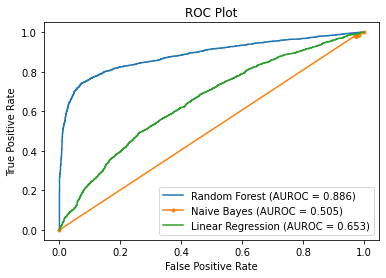

In [38]:
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.plot(lr_fpr, lr_tpr, label='Linear Regression (AUROC = %0.3f)' % lr_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [39]:
important_features = pd.Series(data=clf.feature_importances_,index=X.columns)
print(important_features.sort_values(ascending=False,inplace=True))

None


In [40]:
important_features.head(10)

word_count_scaled      0.119763
reading_ease_scaled    0.089969
genre_Rock             0.041619
EP                     0.027217
genre_Electronic       0.026947
genre_Rap              0.025930
month_June             0.020895
year_2015              0.020138
month_February         0.019823
month_July             0.019678
dtype: float64

In [41]:
X_train.shape

(7397, 163)

In [42]:
rf_probs = clf.predict_proba(X_test_smote)
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]

In [43]:
# calculate scores
rf_auc = roc_auc_score(y_test_smote, rf_probs)

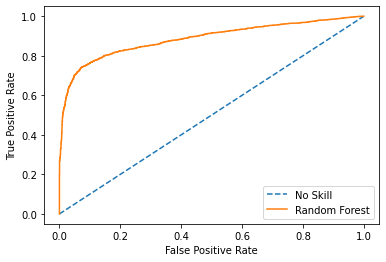

In [44]:
# predict probabilities
yhat = clf.predict_proba(X_test_smote)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_smote, yhat)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, label='Random Forest')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [45]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [46]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.449200, G-Mean=0.830


In [47]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test_smote, yhat)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.449200


In [48]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test_smote, yhat)

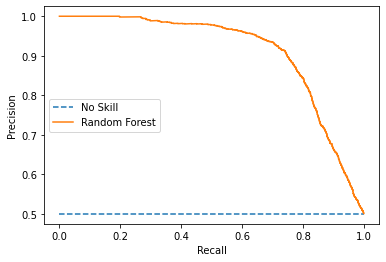

In [49]:
# plot the roc curve for the model
no_skill = len(y_test_smote[y_test_smote==1]) / len(y_test_smote)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, label='Random Forest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [50]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.375589, F-Score=0.822


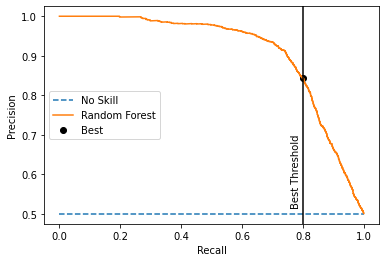

In [51]:
# plot the roc curve for the model
no_skill = len(y_test_smote[y_test_smote==1]) / len(y_test_smote)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, label='Random Forest')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
plt.text(.76,.52,'Best Threshold',rotation=90)
plt.axvline(x = 0.8, 
            color ='black') 
pyplot.show()

In [52]:
# predict labels
yhat = clf.predict(X_test_smote)
# evaluate the model
score = f1_score(y_test_smote, yhat)
print('F-Score: %.5f' % score)

F-Score: 0.79358


In [53]:
# predict probabilities
yhat = clf.predict_proba(X_test_smote)

In [54]:
# keep probabilities for the positive outcome only
probs = yhat[:, 1]

In [55]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)

In [56]:

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [57]:
# evaluate each threshold
scores = [f1_score(y_test_smote, to_labels(probs, t)) for t in thresholds]

In [58]:
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.373, F-Score=0.82145


**Thresholding for accuracy**

In [59]:
def adjust_pred_prob(y_pred_prob, new_threshold):
    """Adjust predicted probabilities to match new threshold value"""
    
    return [1 if y >= new_threshold else 0 for y in y_pred_prob]

In [60]:
rf_clf = clf.predict(X_test_smote)

In [61]:
balanced_accuracy_score(y_test_smote, rf_clf)

0.8209101608473912

In [62]:
accuracy_score(y_test_smote, rf_clf)

0.8209101608473911

In [63]:
thresholds=np.arange(0,1,.01)

In [64]:
pred_prob_rf_clf = clf.predict_proba(X_test_smote)[:,1]

In [65]:
accuracy_points = []

for t in thresholds:
        adjusted_y_pred = adjust_pred_prob(pred_prob_rf_clf, new_threshold=t)
        new_balance = accuracy_score(y_test_smote, adjusted_y_pred)
        accuracy_points.append(new_balance)

In [66]:
balanced_accuracy_points = []

for t in thresholds:
        adjusted_y_pred = adjust_pred_prob(pred_prob_rf_clf, new_threshold=t)
        new_balance = balanced_accuracy_score(y_test_smote, adjusted_y_pred)
        balanced_accuracy_points.append(new_balance)

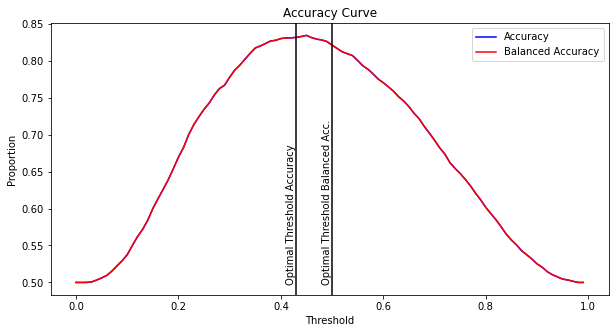

In [69]:
plt.figure(figsize=(10,5))
plt.plot(thresholds, accuracy_points, color='blue')
plt.plot(thresholds, balanced_accuracy_points, color='red')
plt.title('Accuracy Curve')
plt.legend(('Accuracy', 'Balanced Accuracy'))
plt.xlabel('Threshold')
plt.axvline(x=.43, color='black')
plt.text(.41,.5,'Optimal Threshold Accuracy',rotation=90)
plt.axvline(x=.5, color='black')
plt.text(.48,.5,'Optimal Threshold Balanced Acc.',rotation=90)
plt.ylabel('Proportion')
plt.show()